### Prediction of PEC (BDNB)

In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
import random

from heatmap import heatmap, corrplot
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor  
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.inspection import permutation_importance

import shap

random.seed(10)

### Set the directory

In [ ]:
os.chdir("/home/....")

In [252]:
trainx = pd.read_csv("train_bdnb1_all.csv")
testx = pd.read_csv("test_bdnb1_all.csv")

In [32]:
trainx.groupby(['Sector'])['PEC'].mean()

Sector
0    236.477352
1    236.490499
Name: PEC, dtype: float64

In [33]:
testx.groupby(['Sector'])['PEC'].mean()

Sector
0    235.764311
1    236.711572
Name: PEC, dtype: float64

In [77]:
print(trainx.columns)

Index(['Unnamed: 0', 'Floor_area', 'Height', 'Sector', 'U_bay', 'U_wall',
       'U_low_floor', 'Solar_factor', 'Glazing', 'Solar_heat', 'U_high_floor',
       'Climatisation', 'Living_space', 'PEC', 'Construction_year',
       'Type_Appartement', 'Type_Centres commerciaux',
       'Type_Logements collectifs', 'Type_Maison', 'Type_Non résidentiel'],
      dtype='object')


In [253]:
y = trainx[['PEC']]

train = trainx[['Floor_area', 'Height', 'Sector', 'U_bay', 'U_wall',
       'U_low_floor', 'Solar_factor', 'Glazing', 'Solar_heat', 'U_high_floor',
       'Climatisation', 'Living_space',  'Construction_year',
       'Type_Appartement', 'Type_Centres commerciaux',
       'Type_Logements collectifs', 'Type_Maison', 'Type_Non résidentiel']]
               

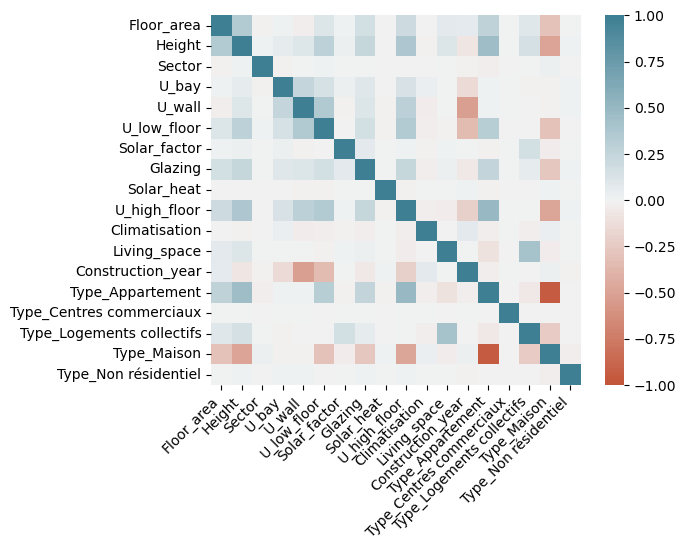

In [230]:
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.savefig("corr.png",dpi=700, bbox_inches = 'tight') 
plt.show()

In [116]:
print(np.shape(y),np.shape(train))

(1151767, 1) (1151767, 18)


In [254]:
y_test = testx[['PEC']]

test = testx[['Floor_area', 'Height', 'Sector', 'U_bay', 'U_wall',
       'U_low_floor', 'Solar_factor', 'Glazing', 'Solar_heat', 'U_high_floor',
       'Climatisation', 'Living_space',  'Construction_year',
       'Type_Appartement', 'Type_Centres commerciaux',
       'Type_Logements collectifs', 'Type_Maison', 'Type_Non résidentiel']]

In [176]:
print(np.shape(y_test),np.shape(test))

(383572, 1) (383572, 18)


In [178]:
print(np.mean(y),np.min(y),np.max(y),np.std(y))

236.48936260545747 0.2 1459.4 PEC    101.291398
dtype: float64


In [120]:
print(np.mean(y_test),np.min(y_test),np.max(y_test),np.std(y_test))

236.62983664083936 1.0 1438.0 PEC    101.566125
dtype: float64


In [257]:
clf = RandomForestRegressor()  
clf.fit(train, y)
clf.predict(test)

/home/fracami/.local/lib/python3.10/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


array([164.402, 267.986, 294.886, ..., 212.995, 215.378, 194.54 ])

In [258]:
y_pred=clf.predict(test)
y_pred[y_pred < 0] = 0
y_t = np.array(y_test)
y_t_pred = clf.predict(train)
y_train = np.array(y)
y_t_pred[y_t_pred < 0] = 0

In [268]:
np.sqrt(np.sum(np.subtract(y_train[:,0],y_t_pred)**2)/np.shape(y_train[:,0])[0])

24.332274175071333

In [273]:
np.sqrt(np.sum(np.subtract(y_t[:,0],y_pred)**2)/np.shape(y_t[:,0])[0])

65.22647482071798

In [274]:
np.mean(np.absolute(np.subtract(y_train[:,0],y_t_pred))/y_train[:,0])

0.07771393460381824

In [275]:
np.mean(np.absolute(np.subtract(y_t[:,0],y_pred))/y_t[:,0])

0.20797817884085398

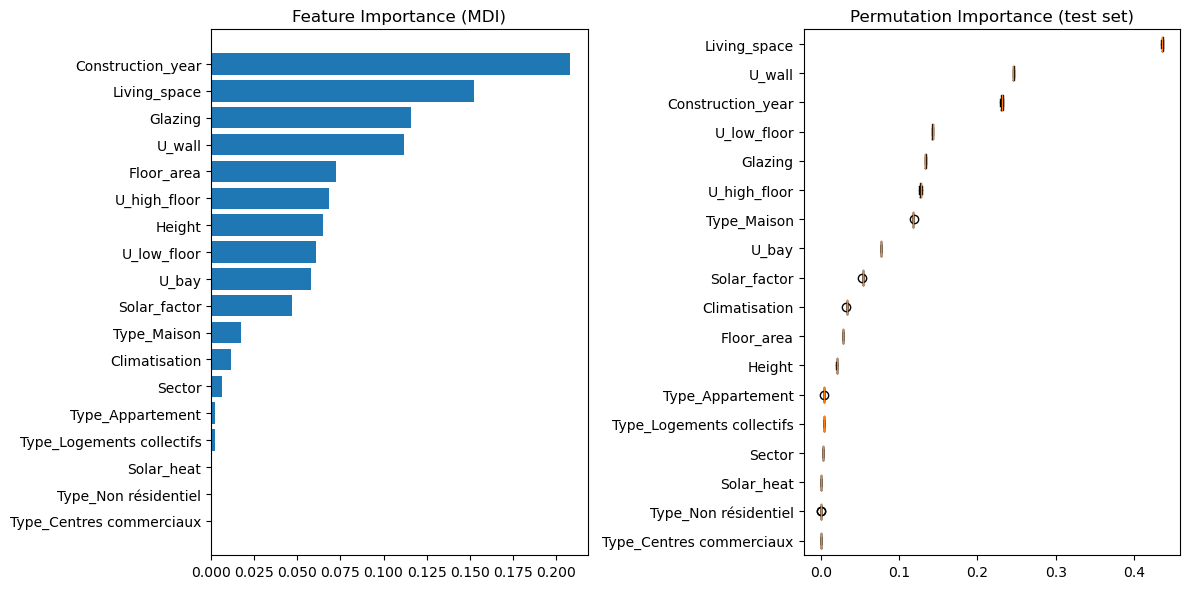

In [205]:
feature_names = list(train.columns)

feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    clf, test, y_test, n_repeats=5, random_state=42
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.savefig('importance_RF1.png')
plt.show()

In [233]:
clf = GradientBoostingRegressor()   
clf.fit(train, y)
clf.predict(test)

y_pred=clf.predict(test)
y_t = np.array(y_test)
y_t_pred = clf.predict(train)
y_train = np.array(y)
y_t_pred[y_t_pred < 0] = 0
y_pred[y_pred < 0] = 0

/home/fracami/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


In [207]:
print("RMSE_train: ", np.sqrt(np.sum(np.subtract(y_train[:,0],y_t_pred)**2)/np.shape(y_train[:,0])[0]),
"RMSE_test: ", np.sqrt(np.sum(np.subtract(y_t[:,0],y_pred)**2)/np.shape(y_t[:,0])[0]),
"MAPE_train: ", np.mean(np.absolute(np.subtract(y_train[:,0],y_t_pred))/y_train[:,0]),
"MAPE_test: ", np.mean(np.absolute(np.subtract(y_t[:,0],y_pred))/y_t[:,0]))

RMSE_train:  77.34352301136288 RMSE_test:  77.56515241981995 MAPE_train:  0.28337922888052675 MAPE_test:  0.2821011816079481


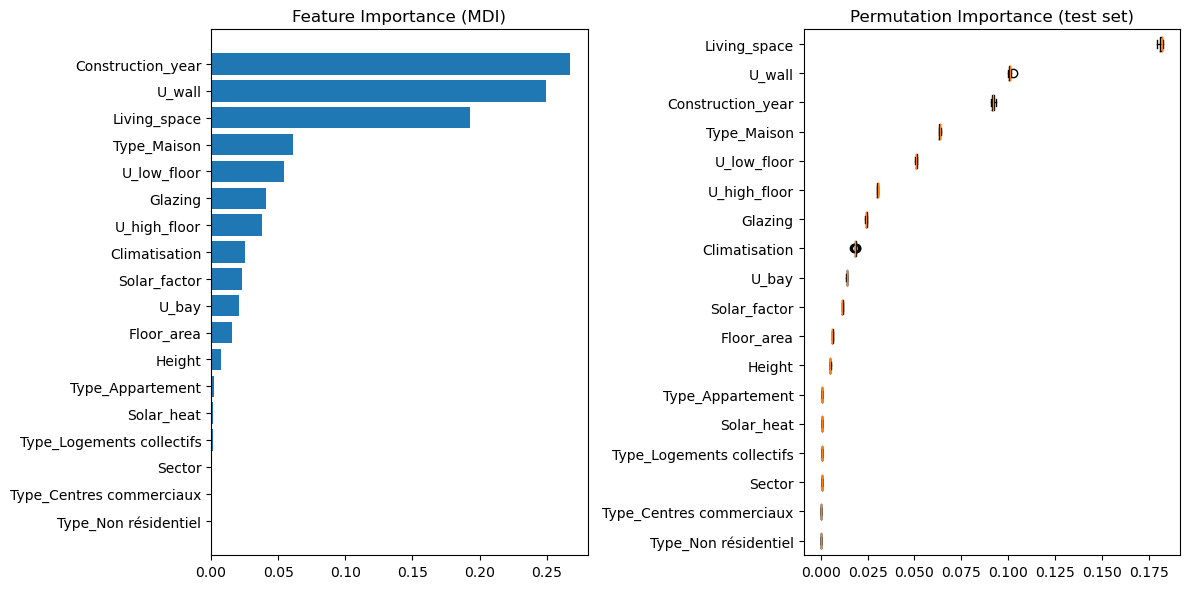

In [208]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    clf, test, y_test, n_repeats=10, random_state=42
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.savefig('importance_GB1.png')
plt.show()

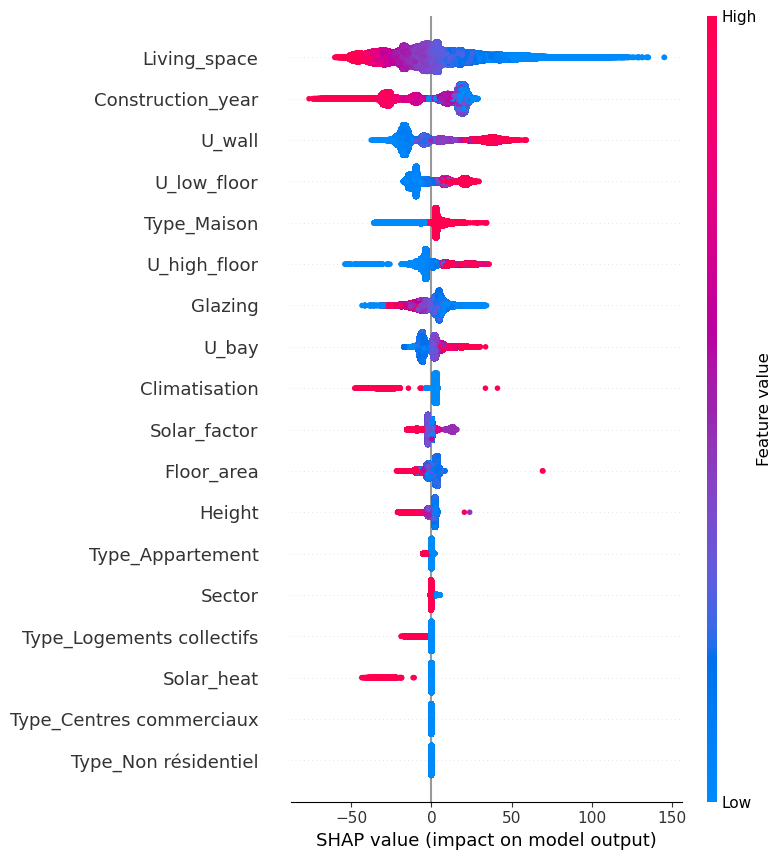

In [234]:
explainer = shap.Explainer(clf)
shap_values = explainer(train)

shap.summary_plot(shap_values, train,max_display=18,show=False)
plt.savefig("shap_GB1.png",dpi=700) 
plt.show()

In [239]:
y = trainx[['PEC']]

train = trainx[[ 'Height', 'Sector', 'U_bay', 'U_wall',
       'U_low_floor', 'Solar_factor', 'Glazing', 'U_high_floor',
       'Climatisation', 'Living_space',  'Construction_year', 'Type_Maison']]
               
y_test = testx[['PEC']]

test = testx[[ 'Height', 'Sector', 'U_bay', 'U_wall',
       'U_low_floor', 'Solar_factor', 'Glazing', 'U_high_floor',
       'Climatisation', 'Living_space',  'Construction_year', 'Type_Maison']]

clf = RandomForestRegressor()  #GradientBoostingRegressor()    RandomForestRegressor()
clf.fit(train, y)
clf.predict(test)

y_pred=clf.predict(test)
y_t = np.array(y_test)
y_t_pred = clf.predict(train)
y_train = np.array(y)
y_t_pred[y_t_pred < 0] = 0
y_pred[y_pred < 0] = 0

print("RMSE_train: ", np.sqrt(np.sum(np.subtract(y_train[:,0],y_t_pred)**2)/np.shape(y_train[:,0])[0]),
"RMSE_test: ", np.sqrt(np.sum(np.subtract(y_t[:,0],y_pred)**2)/np.shape(y_t[:,0])[0]),
"MAPE_train: ", np.mean(np.absolute(np.subtract(y_train[:,0],y_t_pred))/y_train[:,0]),
"MAPE_test: ", np.mean(np.absolute(np.subtract(y_t[:,0],y_pred))/y_t[:,0]))


/home/fracami/.local/lib/python3.10/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE_train:  24.067250055999015 RMSE_test:  64.33268482089403 MAPE_train:  0.07469730116541023 MAPE_test:  0.20002748996342398


### Reduced models

In [237]:
clf = GradientBoostingRegressor()   #GradientBoostingRegressor()    RandomForestRegressor()
clf.fit(train, y)
clf.predict(test)

y_pred=clf.predict(test)
y_t = np.array(y_test)
y_t_pred = clf.predict(train)
y_train = np.array(y)
y_t_pred[y_t_pred < 0] = 0
y_pred[y_pred < 0] = 0

print("RMSE_train: ", np.sqrt(np.sum(np.subtract(y_train[:,0],y_t_pred)**2)/np.shape(y_train[:,0])[0]),
"RMSE_test: ", np.sqrt(np.sum(np.subtract(y_t[:,0],y_pred)**2)/np.shape(y_t[:,0])[0]),
"MAPE_train: ", np.mean(np.absolute(np.subtract(y_train[:,0],y_t_pred))/y_train[:,0]),
"MAPE_test: ", np.mean(np.absolute(np.subtract(y_t[:,0],y_pred))/y_t[:,0]))


/home/fracami/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


RMSE_train:  77.38877553772663 RMSE_test:  77.60235295864001 MAPE_train:  0.28389535403325483 MAPE_test:  0.2824609993006483


In [211]:
y = trainx[['PEC']]

train = trainx[[ 'Height', 'Sector', 'Living_space',  'Construction_year', 'Type_Maison']]
               
y_test = testx[['PEC']]

test = testx[[ 'Height', 'Sector', 'Living_space',  'Construction_year', 'Type_Maison']]

clf = RandomForestRegressor()  #GradientBoostingRegressor()    RandomForestRegressor()
clf.fit(train, y)
clf.predict(test)

y_pred=clf.predict(test)
y_t = np.array(y_test)
y_t_pred = clf.predict(train)
y_train = np.array(y)
y_t_pred[y_t_pred < 0] = 0
y_pred[y_pred < 0] = 0

print("RMSE_train: ", np.sqrt(np.sum(np.subtract(y_train[:,0],y_t_pred)**2)/np.shape(y_train[:,0])[0]),
"RMSE_test: ", np.sqrt(np.sum(np.subtract(y_t[:,0],y_pred)**2)/np.shape(y_t[:,0])[0]),
"MAPE_train: ", np.mean(np.absolute(np.subtract(y_train[:,0],y_t_pred))/y_train[:,0]),
"MAPE_test: ", np.mean(np.absolute(np.subtract(y_t[:,0],y_pred))/y_t[:,0]))

/home/fracami/.local/lib/python3.10/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE_train:  62.247248204995074 RMSE_test:  89.20063807010794 MAPE_train:  0.19900677335403563 MAPE_test:  0.30748584716263344


In [158]:

clf = GradientBoostingRegressor()   #GradientBoostingRegressor()    RandomForestRegressor()
clf.fit(train, y)
clf.predict(test)

y_pred=clf.predict(test)
y_t = np.array(y_test)
y_t_pred = clf.predict(train)
y_train = np.array(y)
y_t_pred[y_t_pred < 0] = 0
y_pred[y_pred < 0] = 0

print("RMSE_train: ", np.sqrt(np.sum(np.subtract(y_train[:,0],y_t_pred)**2)/np.shape(y_train[:,0])[0]),
"RMSE_test: ", np.sqrt(np.sum(np.subtract(y_t[:,0],y_pred)**2)/np.shape(y_t[:,0])[0]),
"MAPE_train: ", np.mean(np.absolute(np.subtract(y_train[:,0],y_t_pred))/y_train[:,0]),
"MAPE_test: ", np.mean(np.absolute(np.subtract(y_t[:,0],y_pred))/y_t[:,0]))

/home/fracami/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


RMSE_train:  85.67532414911716 RMSE_test:  85.93380243371907 MAPE_train:  0.31356272706322696 MAPE_test:  0.31287320993692663


In [212]:
y = trainx[['PEC']]

train = trainx[[ 'Height', 'Sector', 'Construction_year']]
               
y_test = testx[['PEC']]

test = testx[[ 'Height', 'Sector',  'Construction_year']]

clf = RandomForestRegressor()  #GradientBoostingRegressor()    RandomForestRegressor()
clf.fit(train, y)
clf.predict(test)

y_pred=clf.predict(test)
y_t = np.array(y_test)
y_t_pred = clf.predict(train)
y_train = np.array(y)
y_t_pred[y_t_pred < 0] = 0
y_pred[y_pred < 0] = 0

print("RMSE_train: ", np.sqrt(np.sum(np.subtract(y_train[:,0],y_t_pred)**2)/np.shape(y_train[:,0])[0]),
"RMSE_test: ", np.sqrt(np.sum(np.subtract(y_t[:,0],y_pred)**2)/np.shape(y_t[:,0])[0]),
"MAPE_train: ", np.mean(np.absolute(np.subtract(y_train[:,0],y_t_pred))/y_train[:,0]),
"MAPE_test: ", np.mean(np.absolute(np.subtract(y_t[:,0],y_pred))/y_t[:,0]))


/home/fracami/.local/lib/python3.10/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE_train:  89.45065616063502 RMSE_test:  91.64524183257372 MAPE_train:  0.33202313691674157 MAPE_test:  0.33912852570820373


In [165]:
clf = GradientBoostingRegressor()   #GradientBoostingRegressor()    RandomForestRegressor()
clf.fit(train, y)
clf.predict(test)

y_pred=clf.predict(test)
y_t = np.array(y_test)
y_t_pred = clf.predict(train)
y_train = np.array(y)
y_t_pred[y_t_pred < 0] = 0
y_pred[y_pred < 0] = 0

print("RMSE_train: ", np.sqrt(np.sum(np.subtract(y_train[:,0],y_t_pred)**2)/np.shape(y_train[:,0])[0]),
"RMSE_test: ", np.sqrt(np.sum(np.subtract(y_t[:,0],y_pred)**2)/np.shape(y_t[:,0])[0]),
"MAPE_train: ", np.mean(np.absolute(np.subtract(y_train[:,0],y_t_pred))/y_train[:,0]),
"MAPE_test: ", np.mean(np.absolute(np.subtract(y_t[:,0],y_pred))/y_t[:,0]))


/home/fracami/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


RMSE_train:  90.81661231782645 RMSE_test:  91.05655613655483 MAPE_train:  0.339231065878426 MAPE_test:  0.33823267522631933


In [213]:
y = trainx[['PEC']]

train = trainx[[ 'Height', 'Sector']]
               
y_test = testx[['PEC']]

test = testx[[ 'Height', 'Sector']]

clf = RandomForestRegressor()  #GradientBoostingRegressor()    RandomForestRegressor()
clf.fit(train, y)
clf.predict(test)

y_pred=clf.predict(test)
y_t = np.array(y_test)
y_t_pred = clf.predict(train)
y_train = np.array(y)
y_t_pred[y_t_pred < 0] = 0
y_pred[y_pred < 0] = 0

print("RMSE_train: ", np.sqrt(np.sum(np.subtract(y_train[:,0],y_t_pred)**2)/np.shape(y_train[:,0])[0]),
"RMSE_test: ", np.sqrt(np.sum(np.subtract(y_t[:,0],y_pred)**2)/np.shape(y_t[:,0])[0]),
"MAPE_train: ", np.mean(np.absolute(np.subtract(y_train[:,0],y_t_pred))/y_train[:,0]),
"MAPE_test: ", np.mean(np.absolute(np.subtract(y_t[:,0],y_pred))/y_t[:,0]))


/home/fracami/.local/lib/python3.10/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE_train:  101.1257115220556 RMSE_test:  101.45013798177597 MAPE_train:  0.39864790955730844 MAPE_test:  0.3980098349624216


In [171]:
clf = GradientBoostingRegressor()   #GradientBoostingRegressor()    RandomForestRegressor()
clf.fit(train, y)
clf.predict(test)

y_pred=clf.predict(test)
y_t = np.array(y_test)
y_t_pred = clf.predict(train)
y_train = np.array(y)
y_t_pred[y_t_pred < 0] = 0
y_pred[y_pred < 0] = 0

print("RMSE_train: ", np.sqrt(np.sum(np.subtract(y_train[:,0],y_t_pred)**2)/np.shape(y_train[:,0])[0]),
"RMSE_test: ", np.sqrt(np.sum(np.subtract(y_t[:,0],y_pred)**2)/np.shape(y_t[:,0])[0]),
"MAPE_train: ", np.mean(np.absolute(np.subtract(y_train[:,0],y_t_pred))/y_train[:,0]),
"MAPE_test: ", np.mean(np.absolute(np.subtract(y_t[:,0],y_pred))/y_t[:,0]))

/home/fracami/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


RMSE_train:  101.15582684727336 RMSE_test:  101.43136106818805 MAPE_train:  0.3988571283251553 MAPE_test:  0.3979665608675447
